<a href="https://colab.research.google.com/github/TIANBOQIU/AppliedDeepLearning/blob/master/DL_final_Part2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -q openslide-tools
!pip install openslide-python

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 11 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 6s (16.6 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 130812 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ..

In [2]:
!pip install -q tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.1MB 69kB/s 
     |████████████████████████████████| 3.0MB 51.2MB/s 
     |████████████████████████████████| 61kB 28.4MB/s 
     |████████████████████████████████| 419kB 48.4MB/s 


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os 
from PIL import Image
from skimage.color import rgb2gray
import random
import tensorflow as tf
import numpy as np

In [4]:
print(tf.__version__)

2.0.0-alpha0


In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [6]:
import os, re
path_slides = '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/slides'
slides = list(filter(lambda filename: re.match("tumor_[0-9]*\.tif", filename), os.listdir(path_slides)))
masks = list(filter(lambda filename: re.match("tumor_[0-9]*_mask\.tif", filename), os.listdir(path_slides)))
slides = sorted(slides)
masks =sorted(masks)
# tumor_038_mask.tif is missing
slides.remove('tumor_038.tif')
print("total slides {} total masks {}".format(len(slides), len(masks)))
["{} || {}".format(slide, mask) for slide, mask in zip(slides, masks)]

total slides 21 total masks 21


['tumor_001.tif || tumor_001_mask.tif',
 'tumor_002.tif || tumor_002_mask.tif',
 'tumor_005.tif || tumor_005_mask.tif',
 'tumor_012.tif || tumor_012_mask.tif',
 'tumor_016.tif || tumor_016_mask.tif',
 'tumor_019.tif || tumor_019_mask.tif',
 'tumor_023.tif || tumor_023_mask.tif',
 'tumor_031.tif || tumor_031_mask.tif',
 'tumor_035.tif || tumor_035_mask.tif',
 'tumor_057.tif || tumor_057_mask.tif',
 'tumor_059.tif || tumor_059_mask.tif',
 'tumor_064.tif || tumor_064_mask.tif',
 'tumor_075.tif || tumor_075_mask.tif',
 'tumor_078.tif || tumor_078_mask.tif',
 'tumor_081.tif || tumor_081_mask.tif',
 'tumor_084.tif || tumor_084_mask.tif',
 'tumor_091.tif || tumor_091_mask.tif',
 'tumor_094.tif || tumor_094_mask.tif',
 'tumor_096.tif || tumor_096_mask.tif',
 'tumor_101.tif || tumor_101_mask.tif',
 'tumor_110.tif || tumor_110_mask.tif']

In [0]:
# slide paths and masks path
#slide_paths = [os.path.join(path_slides, slide) for slide in slides]
#mask_paths = [os.path.join(path_slides, mask) for mask in masks]

In [0]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

def deep_scan(slide, mask, x, y, s, m, width=50, height=50, lv=0):
  if not slide or not mask:
    print('feed in slide and mask object(openslide object)\n')
    return
  ALL_LEVEL = 8
  mapping_factor = 128 # mapping (x, y) to the (X, Y) at level 0
  patch = None
  print('slide width (x-axis) {}  || depth (y-axis) {} || channel {}'.format(s.shape[1], s.shape[0], s.shape[2])) # if you use np.shape, remember to swap
  print('mask  width (x-axis) {}  || depth (y-axis) {} ||'.format(m.shape[1], m.shape[0]))
  print('deep scan at coordinate: ({:<5} (x-axis), {:<5} (y-aixs))\n'.format(x, y))
  
  # s and m are already np array, not the open-slide object
  if m[y][x]:
    print('this pixel is marked as tumor', '[positive]')
  else:
    print('this pixel is not marked as tumor', '[negative]')
   
  # scan all levels for a (width * height) image
  for i in range(0, ALL_LEVEL):
    plt.subplot(2, 4, i + 1)
    region = read_slide(slide, x=x * mapping_factor, y=y * mapping_factor, level=i, width=width, height=height)
    if i == lv: path = region
    plt.imshow(region)
  
  return patch
  
def get_patch(slide, mask, x, y, width=50, height=50, lv=0):
  if not slide or not mask:
    print('feed in slide and mask object(openslide object)\n')
    return
  ALL_LEVEL = 8
  mapping_factor = 128 # mapping (x, y) to the (X, Y) at level 0
  patch = read_slide(slide, x=x * mapping_factor, y=y * mapping_factor, level=lv, width=width, height=height)
  return patch

def find_tumor_pixels(m):
  return [(j, i) for i, row in enumerate(m)
              for j, c in enumerate(row) if c]

# s: the tumor image at some level
# intensity: threshold to filter the image
def find_tissue_pixels(s, intensity=0.8):
  s_gray = rgb2gray(s)
  idx = np.where(s_gray <= intensity)
  return zip(idx[1], idx[0])

def print_slide(slide_name=None, mask_name=None):
  if not slide_name and not mask_name: return
  path = '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/slides'
  if slide_name:
    slide_path = os.path.join(path, slide_name)
    slide = open_slide(slide_path)
    s = read_slide(slide, x=0, y=0, level=7, width=slide.level_dimensions[7][0], height=slide.level_dimensions[7][1])
    
  if mask_name:
    mask_path = os.path.join(path, mask_name)
    mask = open_slide(mask_path)
    m = read_slide(mask, x=0, y=0, level=7, width=slide.level_dimensions[7][0], height=slide.level_dimensions[7][1])[:,:,0]
  
  plt.figure(figsize=(4, 4), dpi=100)
  if slide_name:
    plt.imshow(s)
    plt.title(slide_path.split('/')[-1])
  if mask_name:
    plt.imshow(m, cmap='jet', alpha=0.5)
  if slide_name and mask_name:
    loc_tissue = list(find_tissue_pixels(s, 0.8))
    loc_tumor = find_tumor_pixels(m)
    print('{:20} || tissue {:10}  ||  tumor {:10} ({:2f}%)'.format(slide_path.split('/')[-1], len(loc_tissue), len(loc_tumor), 100 * len(loc_tumor)/len(loc_tissue)))

def _get_helper(slide_name, mask_name):
  path = '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/slides'
  slide_path, mask_path = os.path.join(path, slide_name), os.path.join(path, mask_name)
  slide, mask = open_slide(slide_path), open_slide(mask_path)
  s = read_slide(slide, x=0, y=0, level=7, width=slide.level_dimensions[7][0], height=slide.level_dimensions[7][1])
  m = read_slide(mask, x=0, y=0, level=7, width=slide.level_dimensions[7][0], height=slide.level_dimensions[7][1])[:,:,0]  
  return slide, mask, s, m
def _get_info(slide_name, mask_name):
  slide, mask, s, m = _get_helper(slide_name, mask_name)
  path = '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/slides'
  slide_path, mask_path = os.path.join(path, slide_name), os.path.join(path, mask_name)
  loc_tissue = list(find_tissue_pixels(s, 0.8))
  loc_tumor = find_tumor_pixels(m)
  print('{:20} || tissue {:10}  ||  tumor {:10} ({:2f}%)'.format(slide_path.split('/')[-1], len(loc_tissue), len(loc_tumor), 100 * len(loc_tumor)/len(loc_tissue)))

def _get_locs(slide_name, mask_name):
  """loc_tissue, loc_tumor, loc_normal"""
  slide, mask, s, m = _get_helper(slide_name, mask_name)
  path = '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/slides'
  slide_path, mask_path = os.path.join(path, slide_name), os.path.join(path, mask_name)
  loc_tissue = list(find_tissue_pixels(s, 0.8))
  loc_tissue = set(loc_tissue)
  loc_tumor = find_tumor_pixels(m)
  loc_tumor = set(loc_tumor)
  loc_normal = loc_tissue - loc_tumor
  return loc_tissue, loc_tumor, loc_normal





In [0]:
def get_patch2(slide, x, y, width=299, height=299, lv=0):
  mapping_factor = 128 # mapping (x, y) to the (X, Y) at level 0
  patch = read_slide(slide, x=x * mapping_factor, y=y * mapping_factor, level=lv, width=width, height=height)
  return patch

def plot_history(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and Validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and Validation loss')
  plt.legend()
  plt.show()

**add training data tumor_078.tif**

tumor_078.tif        || tissue     215836  ||  tumor      59291 (27.470394%)


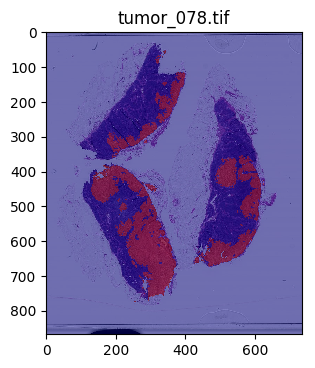

In [9]:
print_slide('tumor_078.tif', 'tumor_078_mask.tif')
path = '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/slides'
slide_name, mask_name = 'tumor_078.tif', 'tumor_078_mask.tif'
slide_path, mask_path = os.path.join(path, slide_name), os.path.join(path, mask_name)
slide, mask = open_slide(slide_path), open_slide(mask_path)
s = read_slide(slide, x=0, y=0, level=7, width=slide.level_dimensions[7][0], height=slide.level_dimensions[7][1])
m = read_slide(mask, x=0, y=0, level=7, width=slide.level_dimensions[7][0], height=slide.level_dimensions[7][1])[:,:,0]  

**load the previous model**

In [17]:
#os.path.exists('/content/gdrive/My Drive/DeepLearning/datasets/model_first.h5')
!cp '/content/gdrive/My Drive/DeepLearning/datasets/model_first.h5' model_first.h5
model = tf.keras.models.load_model('model_first.h5')
model.summary()
  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               33554688  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 33,554,945
Trainable params: 33,554,945
Non-trainable params: 0
_________________________________________________________________


*The current training data will  be 20 times larger compared with the previous training data, and can not fit into the memory at once. I could build a generator or split the traning set manually. The previous data size is 5848.*

In [12]:
_get_info('tumor_091.tif', 'tumor_091_mask.tif')
_get_info('tumor_078.tif', 'tumor_078_mask.tif')

tumor_091.tif        || tissue      62589  ||  tumor       2924 (4.671747%)
tumor_078.tif        || tissue     215836  ||  tumor      59291 (27.470394%)


**feature extraction**

In [0]:
from tensorflow.keras.applications import ResNet50, InceptionV3
conv_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

In [0]:
loc_tissue, loc_tumor, loc_normal = _get_locs('tumor_078.tif', 'tumor_078_mask.tif')
# shuffle loc_normal and get balanced data
normal = list(loc_normal)
random.shuffle(normal)
normal = normal[:len(loc_tumor)]

In [12]:
print('tumor patches {} normal patches {} total {}'.format(len(loc_tumor), len(normal), len(loc_tumor)+len(normal)))

tumor patches 59291 normal patches 59291 total 118582


In [16]:
118582 / 5848

20.277359781121753

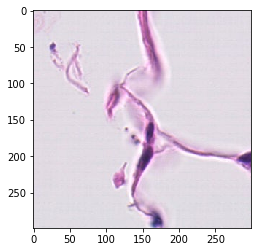

In [22]:
patch = get_patch2(slide, *random.choice(normal))
plt.imshow(patch)

divide into 30 parts to train

In [0]:
batch1 = slice(0, 2000)
#list(loc_tumor)[batch1]

In [0]:
# batch 1
batch1 = slice(0, 2000)
images = []
labels = []
for i, loc in enumerate(list(loc_tumor)[batch1]):
  patch = get_patch2(slide, *loc, 299, 299, 4)
  images.append(patch)
  labels.append(1)
  if i % 100 == 0: print('processing {:<2f}%'.format(100 *(i + 1) / len(list(loc_tumor)[batch1]) ))
for i, loc in enumerate(list(normal)[batch1]):
  patch = get_patch2(slide, *loc, 299, 299, 4)
  images.append(patch)
  labels.append(0)
  if i % 100 == 0: print('processing {:<2f}%'.format(100 *(i + 1) / len(normal[batch1]) ))
images = np.array(images)    
labels = np.array(labels)

processing 0.050000%
processing 5.050000%
processing 10.050000%
processing 15.050000%
processing 20.050000%
processing 25.050000%
processing 30.050000%
processing 35.050000%
processing 40.050000%
processing 45.050000%
processing 50.050000%
processing 55.050000%
processing 60.050000%
processing 65.050000%
processing 70.050000%
processing 75.050000%
processing 80.050000%
processing 85.050000%
processing 90.050000%
processing 95.050000%
processing 0.050000%
processing 5.050000%
processing 10.050000%
processing 15.050000%
processing 20.050000%
processing 25.050000%
processing 30.050000%
processing 35.050000%
processing 40.050000%
processing 45.050000%
processing 50.050000%
processing 55.050000%
processing 60.050000%
processing 65.050000%
processing 70.050000%
processing 75.050000%
processing 80.050000%
processing 85.050000%
processing 90.050000%
processing 95.050000%


In [0]:
features = conv_base.predict(images)

In [0]:
train_features = np.reshape(features, (len(features), -1))
history = model.fit(train_features, labels, epochs=20, batch_size=128, validation_split=0.2)

Train on 3200 samples, validate on 800 samples
Epoch 1/20
3200/3200 [==============================] - 3s 924us/sample - loss: 4.6476 - acc: 0.7284 - val_loss: 2.0193 - val_acc: 0.7325
Epoch 2/20
3200/3200 [==============================] - 2s 538us/sample - loss: 0.9950 - acc: 0.7831 - val_loss: 1.1777 - val_acc: 0.6162
Epoch 3/20
3200/3200 [==============================] - 2s 537us/sample - loss: 0.5368 - acc: 0.8178 - val_loss: 0.8270 - val_acc: 0.6500
Epoch 4/20
3200/3200 [==============================] - 2s 523us/sample - loss: 0.4379 - acc: 0.8306 - val_loss: 0.9568 - val_acc: 0.5825
Epoch 5/20
3200/3200 [==============================] - 2s 534us/sample - loss: 0.3995 - acc: 0.8450 - val_loss: 1.0236 - val_acc: 0.5512
Epoch 6/20
3200/3200 [==============================] - 2s 520us/sample - loss: 0.3645 - acc: 0.8572 - val_loss: 0.4866 - val_acc: 0.7975
Epoch 7/20
3200/3200 [==============================] - 2s 518us/sample - loss: 0.3413 - acc: 0.8612 - val_loss: 0.7643 - val

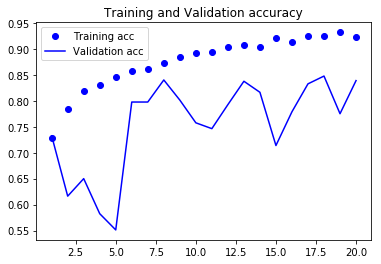

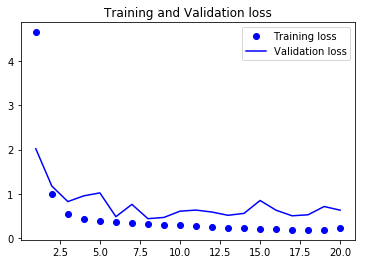

In [0]:
plot_history(history)

In [0]:
model.save('model_second0-2000.h5')
!cp 'model_second0-2000.h5' '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/models/model_second0-2000.h5'

In [0]:
# free memory
import gc
del images
del labels
del features
del train_features

In [0]:
!rm 'model_second0-2000.h5'

reset the model and automate it

In [0]:
model = tf.keras.models.load_model('model_first.h5')

In [20]:
# shuffle
len(normal), len(loc_tumor)
random.shuffle(normal)
len(normal)
tumor = list(loc_tumor)
len(tumor)
random.shuffle(tumor)
len(normal), len(tumor)

(59291, 59291)

In [0]:
import gc
def _train_on_batch(batch_size=2000):
  for i in range(0, len(normal), batch_size):
    print('training on batch {} / {}'.format(i//batch_size+1, len(normal)//batch_size))
    batch = slice(i, i + batch_size)
    for i, loc in enumerate(tumor[batch]): # 5/4 sencond throughtm bug here? same i
      images = []
      labels = []
      patch = get_patch2(slide, *loc, 299, 299, 4)
      images.append(patch)
      labels.append(1)
      if i % 1000 == 0: print('processing {:<2f}%'.format(100 *(i + 1) / batch_size ))
    for i, loc in enumerate(normal[batch]):
      patch = get_patch2(slide, *loc, 299, 299, 4)
      images.append(patch)
      labels.append(0)
      if i % 1000 == 0: print('processing {:<2f}%'.format(100 *(i + 1) / batch_size ))
    images = np.array(images)    
    labels = np.array(labels)    
    features = conv_base.predict(images)
    train_features = np.reshape(features, (len(features), -1))
    del features
    history = model.fit(train_features, labels, epochs=20, batch_size=128, validation_split=0.1)
    plot_history(history)
    save_dir = '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/models/model_third_batch{}.h5'.format(i+1)
    model.save(save_dir)
    del images
    del labels
    del train_features

training on batch 1 / 14
processing 0.025000%
processing 25.025000%
processing 50.025000%
processing 75.025000%
processing 0.025000%
processing 25.025000%
processing 50.025000%
processing 75.025000%
Train on 3600 samples, validate on 401 samples
Epoch 1/20
3600/3600 [==============================] - 2s 545us/sample - loss: 0.1144 - acc: 0.9964 - val_loss: 9.1012e-07 - val_acc: 1.0000
Epoch 2/20
3600/3600 [==============================] - 2s 481us/sample - loss: 0.0132 - acc: 0.9997 - val_loss: 2.4802e-07 - val_acc: 1.0000
Epoch 3/20
3600/3600 [==============================] - 2s 484us/sample - loss: 0.0098 - acc: 0.9994 - val_loss: 7.9841e-08 - val_acc: 1.0000
Epoch 4/20
3600/3600 [==============================] - 2s 481us/sample - loss: 0.0074 - acc: 0.9997 - val_loss: 4.1836e-08 - val_acc: 1.0000
Epoch 5/20
3600/3600 [==============================] - 2s 487us/sample - loss: 0.0102 - acc: 0.9994 - val_loss: 1.5485e-08 - val_acc: 1.0000
Epoch 6/20
3600/3600 [======================

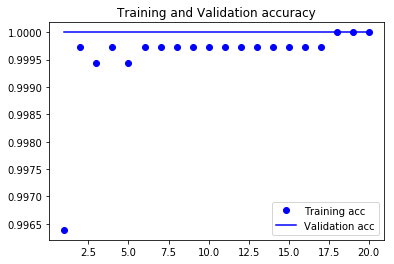

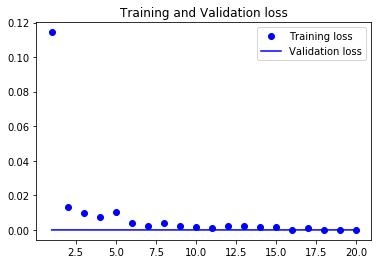

training on batch 2 / 14
processing 0.025000%
processing 25.025000%
processing 50.025000%
processing 75.025000%
processing 0.025000%
processing 25.025000%
processing 50.025000%
processing 75.025000%
Train on 3600 samples, validate on 401 samples
Epoch 1/20
3600/3600 [==============================] - 2s 471us/sample - loss: 0.0237 - acc: 0.9997 - val_loss: 5.8270e-12 - val_acc: 1.0000
Epoch 2/20
3600/3600 [==============================] - 2s 470us/sample - loss: 0.0161 - acc: 0.9997 - val_loss: 4.9991e-12 - val_acc: 1.0000
Epoch 3/20
3600/3600 [==============================] - 2s 474us/sample - loss: 0.0134 - acc: 0.9997 - val_loss: 4.8714e-12 - val_acc: 1.0000
Epoch 4/20
3600/3600 [==============================] - 2s 468us/sample - loss: 0.0103 - acc: 0.9997 - val_loss: 1.4975e-11 - val_acc: 1.0000
Epoch 5/20
3600/3600 [==============================] - 2s 478us/sample - loss: 0.0059 - acc: 0.9997 - val_loss: 2.1205e-10 - val_acc: 1.0000
Epoch 6/20
3600/3600 [======================

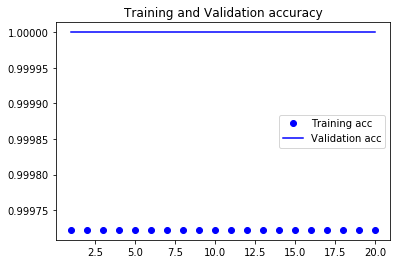

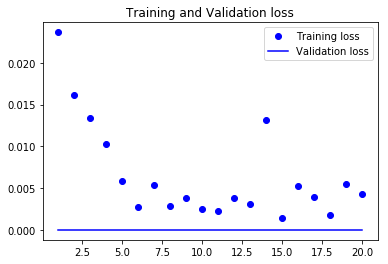

training on batch 3 / 14
processing 0.025000%
processing 25.025000%
processing 50.025000%
processing 75.025000%
processing 0.025000%
processing 25.025000%
processing 50.025000%
processing 75.025000%
Train on 3600 samples, validate on 401 samples
Epoch 1/20
3600/3600 [==============================] - 2s 494us/sample - loss: 0.0148 - acc: 0.9997 - val_loss: 1.4433e-11 - val_acc: 1.0000
Epoch 2/20
3600/3600 [==============================] - 2s 488us/sample - loss: 0.0105 - acc: 0.9994 - val_loss: 2.5090e-11 - val_acc: 1.0000
Epoch 3/20
3600/3600 [==============================] - 2s 485us/sample - loss: 0.0046 - acc: 0.9992 - val_loss: 1.3599e-11 - val_acc: 1.0000
Epoch 4/20
3600/3600 [==============================] - 2s 479us/sample - loss: 0.0050 - acc: 0.9997 - val_loss: 2.0201e-11 - val_acc: 1.0000
Epoch 5/20
3600/3600 [==============================] - 2s 480us/sample - loss: 0.0098 - acc: 0.9992 - val_loss: 1.5711e-11 - val_acc: 1.0000
Epoch 6/20
3600/3600 [======================

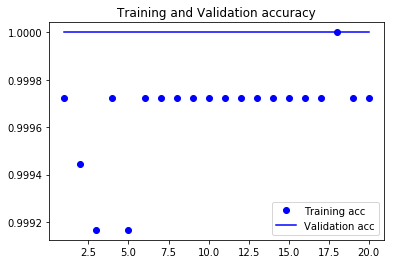

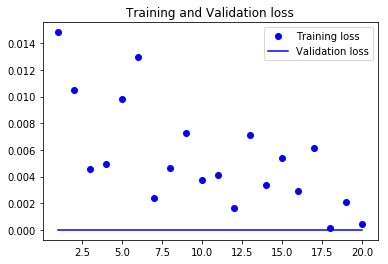

training on batch 4 / 14
processing 0.025000%
processing 25.025000%
processing 50.025000%
processing 75.025000%
processing 0.025000%
processing 25.025000%
processing 50.025000%
processing 75.025000%
Train on 3600 samples, validate on 401 samples
Epoch 1/20
3600/3600 [==============================] - 2s 481us/sample - loss: 0.0863 - acc: 0.9997 - val_loss: 2.0113e-11 - val_acc: 1.0000
Epoch 2/20
3600/3600 [==============================] - 2s 485us/sample - loss: 0.0441 - acc: 0.9997 - val_loss: 3.6759e-11 - val_acc: 1.0000
Epoch 3/20
3600/3600 [==============================] - 2s 479us/sample - loss: 0.0530 - acc: 0.9997 - val_loss: 6.1306e-11 - val_acc: 1.0000
Epoch 4/20
3600/3600 [==============================] - 2s 480us/sample - loss: 0.0356 - acc: 0.9997 - val_loss: 5.8479e-11 - val_acc: 1.0000
Epoch 5/20
3600/3600 [==============================] - 2s 483us/sample - loss: 0.0087 - acc: 0.9997 - val_loss: 3.9960e-11 - val_acc: 1.0000
Epoch 6/20
3600/3600 [======================

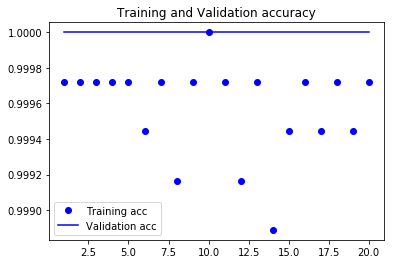

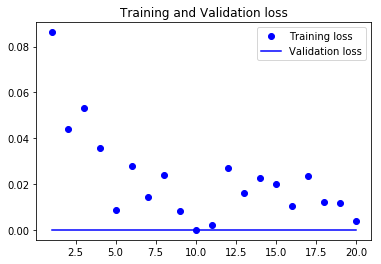

training on batch 5 / 14
processing 0.025000%
processing 25.025000%
processing 50.025000%
processing 75.025000%
processing 0.025000%
processing 25.025000%
processing 50.025000%
processing 75.025000%
Train on 3600 samples, validate on 401 samples
Epoch 1/20
3600/3600 [==============================] - 2s 481us/sample - loss: 0.0298 - acc: 0.9994 - val_loss: 2.0321e-10 - val_acc: 1.0000
Epoch 2/20
3600/3600 [==============================] - 2s 490us/sample - loss: 0.0235 - acc: 0.9997 - val_loss: 4.5536e-10 - val_acc: 1.0000
Epoch 3/20
3600/3600 [==============================] - 2s 497us/sample - loss: 0.0168 - acc: 0.9994 - val_loss: 3.5914e-10 - val_acc: 1.0000
Epoch 4/20
3600/3600 [==============================] - 2s 503us/sample - loss: 0.0110 - acc: 0.9997 - val_loss: 4.6356e-10 - val_acc: 1.0000
Epoch 5/20
3600/3600 [==============================] - 2s 496us/sample - loss: 0.0101 - acc: 0.9997 - val_loss: 4.4257e-10 - val_acc: 1.0000
Epoch 6/20
3600/3600 [======================

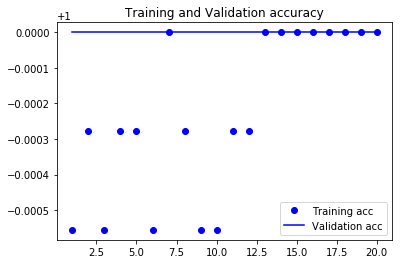

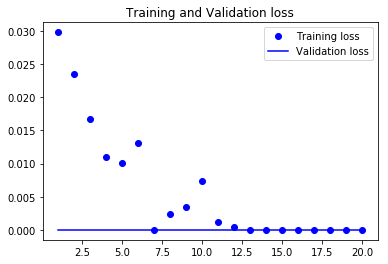

training on batch 6 / 14
processing 0.025000%
processing 25.025000%
processing 50.025000%
processing 75.025000%
processing 0.025000%
processing 25.025000%
processing 50.025000%
processing 75.025000%
Train on 3600 samples, validate on 401 samples
Epoch 1/20
3600/3600 [==============================] - 2s 474us/sample - loss: 0.0561 - acc: 0.9997 - val_loss: 8.7795e-11 - val_acc: 1.0000
Epoch 2/20
3600/3600 [==============================] - 2s 478us/sample - loss: 0.0271 - acc: 0.9994 - val_loss: 4.6049e-11 - val_acc: 1.0000
Epoch 3/20
3600/3600 [==============================] - 2s 473us/sample - loss: 0.0100 - acc: 0.9997 - val_loss: 5.4060e-11 - val_acc: 1.0000
Epoch 4/20
3600/3600 [==============================] - 2s 478us/sample - loss: 0.0187 - acc: 0.9992 - val_loss: 1.2287e-11 - val_acc: 1.0000
Epoch 5/20
3600/3600 [==============================] - 2s 478us/sample - loss: 0.0195 - acc: 0.9997 - val_loss: 4.4403e-11 - val_acc: 1.0000
Epoch 6/20
3600/3600 [======================

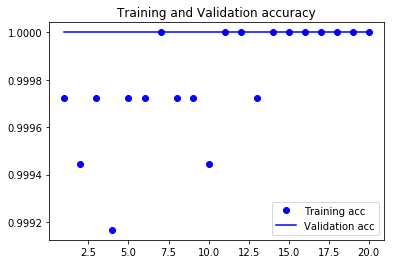

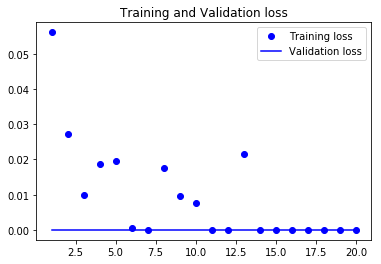

training on batch 7 / 14
processing 0.025000%
processing 25.025000%
processing 50.025000%
processing 75.025000%
processing 0.025000%
processing 25.025000%
processing 50.025000%
processing 75.025000%
Train on 3600 samples, validate on 401 samples
Epoch 1/20
3600/3600 [==============================] - 2s 533us/sample - loss: 0.0754 - acc: 0.9997 - val_loss: 1.2135e-10 - val_acc: 1.0000
Epoch 2/20
3600/3600 [==============================] - 2s 538us/sample - loss: 0.0268 - acc: 0.9992 - val_loss: 1.0534e-10 - val_acc: 1.0000
Epoch 3/20
3600/3600 [==============================] - 2s 542us/sample - loss: 0.0385 - acc: 0.9997 - val_loss: 1.9321e-10 - val_acc: 1.0000
Epoch 4/20
3600/3600 [==============================] - 2s 542us/sample - loss: 0.0329 - acc: 0.9997 - val_loss: 3.1156e-10 - val_acc: 1.0000
Epoch 5/20
3600/3600 [==============================] - 2s 546us/sample - loss: 0.0184 - acc: 0.9997 - val_loss: 3.8338e-10 - val_acc: 1.0000
Epoch 6/20
3600/3600 [======================

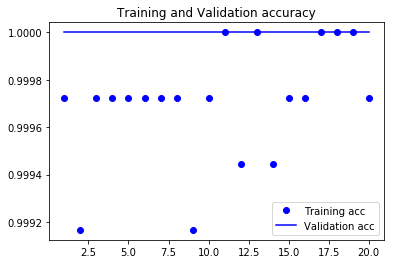

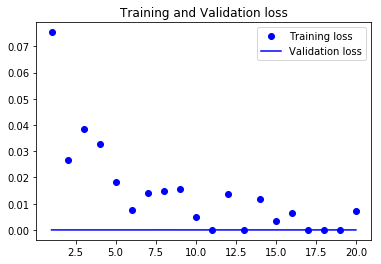

training on batch 8 / 14
processing 0.025000%
processing 25.025000%
processing 50.025000%
processing 75.025000%
processing 0.025000%
processing 25.025000%
processing 50.025000%
processing 75.025000%
Train on 3600 samples, validate on 401 samples
Epoch 1/20
3600/3600 [==============================] - 2s 464us/sample - loss: 0.0212 - acc: 0.9994 - val_loss: 2.1561e-11 - val_acc: 1.0000
Epoch 2/20
3600/3600 [==============================] - 2s 467us/sample - loss: 0.0229 - acc: 0.9994 - val_loss: 3.0226e-11 - val_acc: 1.0000
Epoch 3/20
3600/3600 [==============================] - 2s 469us/sample - loss: 0.0152 - acc: 0.9994 - val_loss: 2.9269e-11 - val_acc: 1.0000
Epoch 4/20
3600/3600 [==============================] - 2s 471us/sample - loss: 0.0086 - acc: 0.9997 - val_loss: 3.6267e-11 - val_acc: 1.0000
Epoch 5/20
3600/3600 [==============================] - 2s 469us/sample - loss: 0.0114 - acc: 0.9994 - val_loss: 5.6097e-11 - val_acc: 1.0000
Epoch 6/20
3600/3600 [======================

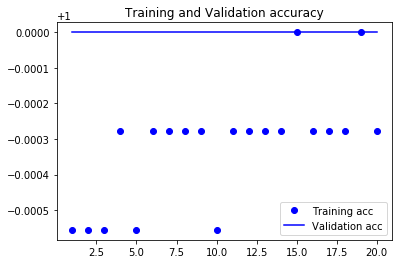

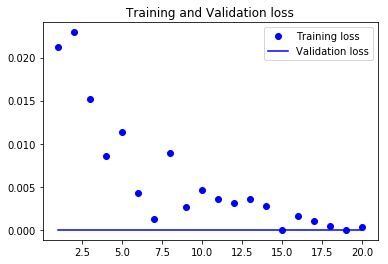

training on batch 9 / 14
processing 0.025000%
processing 25.025000%
processing 50.025000%
processing 75.025000%
processing 0.025000%
processing 25.025000%
processing 50.025000%
processing 75.025000%
Train on 3600 samples, validate on 401 samples
Epoch 1/20
3600/3600 [==============================] - 2s 469us/sample - loss: 0.0065 - acc: 0.9997 - val_loss: 1.7545e-11 - val_acc: 1.0000
Epoch 2/20
3600/3600 [==============================] - 2s 473us/sample - loss: 0.0120 - acc: 0.9997 - val_loss: 2.4140e-11 - val_acc: 1.0000
Epoch 3/20
3600/3600 [==============================] - 2s 469us/sample - loss: 0.0043 - acc: 0.9997 - val_loss: 1.7801e-11 - val_acc: 1.0000
Epoch 4/20
3600/3600 [==============================] - 2s 474us/sample - loss: 0.0066 - acc: 0.9997 - val_loss: 3.1781e-11 - val_acc: 1.0000
Epoch 5/20
3600/3600 [==============================] - 2s 466us/sample - loss: 0.0108 - acc: 0.9997 - val_loss: 1.7706e-11 - val_acc: 1.0000
Epoch 6/20
3600/3600 [======================

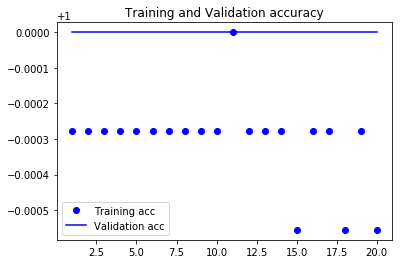

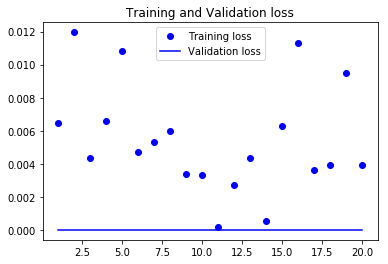

training on batch 10 / 14
processing 0.025000%
processing 25.025000%
processing 50.025000%
processing 75.025000%
processing 0.025000%
processing 25.025000%
processing 50.025000%
processing 75.025000%
Train on 3600 samples, validate on 401 samples
Epoch 1/20
3600/3600 [==============================] - 2s 474us/sample - loss: 0.0383 - acc: 0.9997 - val_loss: 1.0844e-10 - val_acc: 1.0000
Epoch 2/20
3600/3600 [==============================] - 2s 475us/sample - loss: 0.0378 - acc: 0.9997 - val_loss: 5.2499e-11 - val_acc: 1.0000
Epoch 3/20
3600/3600 [==============================] - 2s 471us/sample - loss: 0.0269 - acc: 0.9997 - val_loss: 1.7205e-07 - val_acc: 1.0000
Epoch 4/20
3600/3600 [==============================] - 2s 470us/sample - loss: 0.0162 - acc: 0.9997 - val_loss: 4.9251e-08 - val_acc: 1.0000
Epoch 5/20
3600/3600 [==============================] - 2s 475us/sample - loss: 0.0185 - acc: 0.9997 - val_loss: 1.7063e-07 - val_acc: 1.0000
Epoch 6/20
3600/3600 [=====================

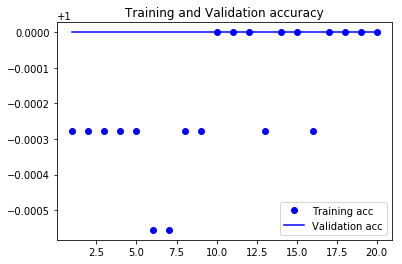

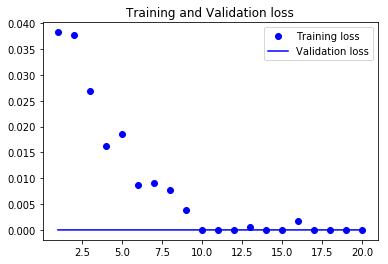

training on batch 11 / 14
processing 0.025000%
processing 25.025000%
processing 50.025000%
processing 75.025000%
processing 0.025000%
processing 25.025000%
processing 50.025000%
processing 75.025000%
Train on 3600 samples, validate on 401 samples
Epoch 1/20
3600/3600 [==============================] - 2s 508us/sample - loss: 0.0327 - acc: 0.9997 - val_loss: 1.4599e-11 - val_acc: 1.0000
Epoch 2/20
3600/3600 [==============================] - 2s 513us/sample - loss: 0.0036 - acc: 0.9997 - val_loss: 8.9664e-12 - val_acc: 1.0000
Epoch 3/20
3600/3600 [==============================] - 2s 508us/sample - loss: 0.0103 - acc: 0.9997 - val_loss: 3.3009e-12 - val_acc: 1.0000
Epoch 4/20
3600/3600 [==============================] - 2s 513us/sample - loss: 0.0148 - acc: 0.9994 - val_loss: 1.9634e-12 - val_acc: 1.0000
Epoch 5/20
3600/3600 [==============================] - 2s 511us/sample - loss: 0.0161 - acc: 0.9997 - val_loss: 2.0872e-12 - val_acc: 1.0000
Epoch 6/20
3600/3600 [=====================

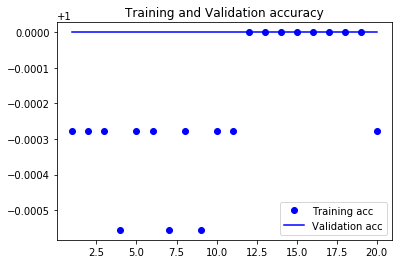

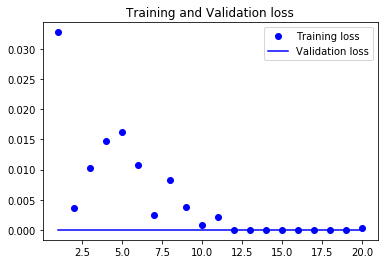

training on batch 12 / 14
processing 0.025000%
processing 25.025000%
processing 50.025000%
processing 75.025000%
processing 0.025000%
processing 25.025000%
processing 50.025000%
processing 75.025000%
Train on 3600 samples, validate on 401 samples
Epoch 1/20
3600/3600 [==============================] - 2s 498us/sample - loss: 0.0061 - acc: 0.9997 - val_loss: 5.9783e-12 - val_acc: 1.0000
Epoch 2/20
3600/3600 [==============================] - 2s 504us/sample - loss: 0.0215 - acc: 0.9997 - val_loss: 9.1615e-12 - val_acc: 1.0000
Epoch 3/20
3600/3600 [==============================] - 2s 498us/sample - loss: 0.0040 - acc: 0.9997 - val_loss: 3.8747e-10 - val_acc: 1.0000
Epoch 4/20
3600/3600 [==============================] - 2s 497us/sample - loss: 0.0045 - acc: 0.9994 - val_loss: 7.3768e-12 - val_acc: 1.0000
Epoch 5/20
3600/3600 [==============================] - 2s 497us/sample - loss: 0.0035 - acc: 0.9997 - val_loss: 9.6412e-12 - val_acc: 1.0000
Epoch 6/20
3600/3600 [=====================

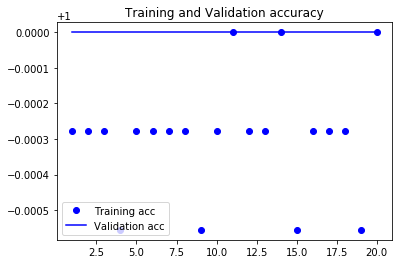

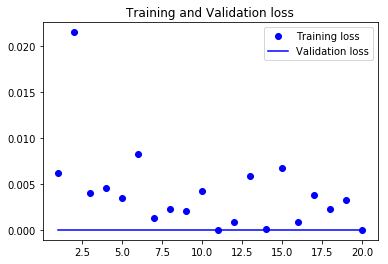

training on batch 13 / 14
processing 0.025000%
processing 25.025000%
processing 50.025000%
processing 75.025000%
processing 0.025000%
processing 25.025000%
processing 50.025000%
processing 75.025000%
Train on 3600 samples, validate on 401 samples
Epoch 1/20
3600/3600 [==============================] - 2s 522us/sample - loss: 0.0256 - acc: 0.9997 - val_loss: 2.3754e-12 - val_acc: 1.0000
Epoch 2/20
3600/3600 [==============================] - 2s 519us/sample - loss: 0.0166 - acc: 0.9997 - val_loss: 3.5359e-12 - val_acc: 1.0000
Epoch 3/20
3600/3600 [==============================] - 2s 514us/sample - loss: 0.0143 - acc: 0.9997 - val_loss: 2.3908e-11 - val_acc: 1.0000
Epoch 4/20
3600/3600 [==============================] - 2s 520us/sample - loss: 0.0101 - acc: 0.9997 - val_loss: 3.2659e-12 - val_acc: 1.0000
Epoch 5/20
3600/3600 [==============================] - 2s 520us/sample - loss: 0.0187 - acc: 0.9994 - val_loss: 9.3740e-12 - val_acc: 1.0000
Epoch 6/20
3600/3600 [=====================

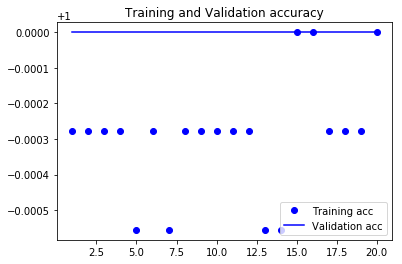

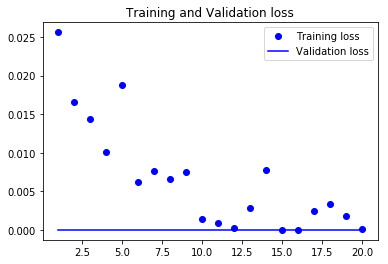

training on batch 14 / 14
processing 0.025000%
processing 25.025000%
processing 50.025000%
processing 75.025000%
processing 0.025000%
processing 25.025000%
processing 50.025000%
processing 75.025000%
Train on 3600 samples, validate on 401 samples
Epoch 1/20
3600/3600 [==============================] - 2s 505us/sample - loss: 0.0227 - acc: 0.9994 - val_loss: 1.0556e-12 - val_acc: 1.0000
Epoch 2/20
3600/3600 [==============================] - 2s 502us/sample - loss: 0.0345 - acc: 0.9994 - val_loss: 2.7422e-12 - val_acc: 1.0000
Epoch 3/20
3600/3600 [==============================] - 2s 501us/sample - loss: 0.0177 - acc: 0.9997 - val_loss: 5.0036e-12 - val_acc: 1.0000
Epoch 4/20
3600/3600 [==============================] - 2s 505us/sample - loss: 0.0111 - acc: 0.9997 - val_loss: 5.9068e-12 - val_acc: 1.0000
Epoch 5/20
3600/3600 [==============================] - 2s 508us/sample - loss: 0.0032 - acc: 0.9997 - val_loss: 8.0095e-12 - val_acc: 1.0000
Epoch 6/20
3600/3600 [=====================

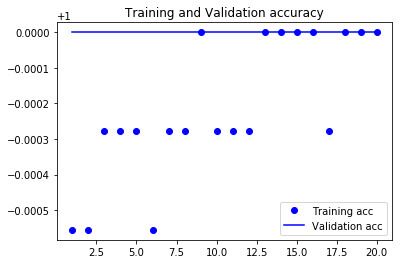

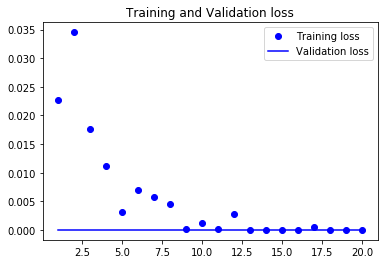

training on batch 15 / 14
processing 0.025000%
processing 25.025000%
processing 50.025000%
processing 75.025000%
processing 0.025000%
processing 25.025000%
processing 50.025000%
processing 75.025000%
Train on 2962 samples, validate on 330 samples
Epoch 1/20
2962/2962 [==============================] - 1s 487us/sample - loss: 0.0300 - acc: 0.9997 - val_loss: 1.5082e-11 - val_acc: 1.0000
Epoch 2/20
2962/2962 [==============================] - 1s 480us/sample - loss: 0.0166 - acc: 0.9993 - val_loss: 1.4994e-11 - val_acc: 1.0000
Epoch 3/20
2962/2962 [==============================] - 1s 479us/sample - loss: 0.0187 - acc: 0.9997 - val_loss: 2.0311e-11 - val_acc: 1.0000
Epoch 4/20
2962/2962 [==============================] - 1s 477us/sample - loss: 0.0119 - acc: 0.9993 - val_loss: 1.3875e-11 - val_acc: 1.0000
Epoch 5/20
2962/2962 [==============================] - 1s 473us/sample - loss: 0.0081 - acc: 0.9993 - val_loss: 1.3755e-11 - val_acc: 1.0000
Epoch 6/20
2962/2962 [=====================

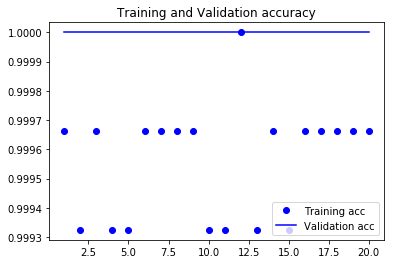

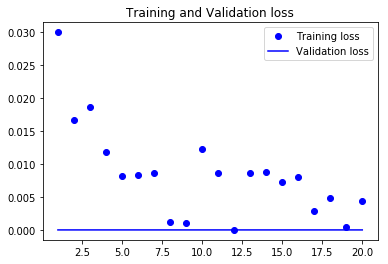

In [0]:
_train_on_batch(4000)

why overfit like this?

**make prediction**

In [0]:
tissue = list(loc_tissue)
len(tissue)

215836

In [0]:
images = []
batch = slice(0, 4000)
for loc in tissue[batch]:
  patch = get_patch2(slide, *loc, 299, 299, 4)
  images.append(patch)
images = np.array(images)
images = conv_base.predict(images)
pred = model.predict(images)

In [0]:
images.shape
np.reshape(images, (4000,-1)).shape

(4000, 131072)

In [0]:
#pred = model.predict(images)
pred[100:110]

array([[0.91279274],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]], dtype=float32)

In [0]:
#del images
#gc.collect()

31866

In [0]:
tissue = list(loc_tissue)
pred = []
batch_size = 4000
for i in range(0, len(tissue), batch_size):
    print('training on batch {} / {}'.format(i//batch_size+1, len(normal)//batch_size))
    batch = slice(i, i + batch_size)
    for i, loc in enumerate(tumor[batch]):
      images = []
      labels = []
      patch = get_patch2(slide, *loc, 299, 299, 4)
      images.append(patch)
      labels.append(1)

In [0]:
import gc

def _get_pred(batch_size=4000):
  prediction = []
  for i in range(0, len(tissue), batch_size):
    print('predicting on batch {} / {}'.format(i//batch_size, len(tissue)//batch_size))
    batch = slice(i, i + batch_size)
    images = [get_patch2(slide, *loc, 299, 299, 4) for loc in tissue[batch]]
    images = np.array(images)
    images = conv_base.predict(images)
    images = np.reshape(images, (len(images), -1))
    pred = model.predict(images)
    del images
    prediction.append(pred)
  return prediction

In [0]:
import time
_start_time = time.time()
prediction = _get_pred(4000)
print('Done {}'.format(time.time() - _start_time))

predicting on batch 0 / 53
predicting on batch 1 / 53
predicting on batch 2 / 53
predicting on batch 3 / 53
predicting on batch 4 / 53
predicting on batch 5 / 53
predicting on batch 6 / 53
predicting on batch 7 / 53
predicting on batch 8 / 53
predicting on batch 9 / 53
predicting on batch 10 / 53
predicting on batch 11 / 53
predicting on batch 12 / 53
predicting on batch 13 / 53
predicting on batch 14 / 53
predicting on batch 15 / 53
predicting on batch 16 / 53
predicting on batch 17 / 53
predicting on batch 18 / 53
predicting on batch 19 / 53
predicting on batch 20 / 53
predicting on batch 21 / 53
predicting on batch 22 / 53
predicting on batch 23 / 53
predicting on batch 24 / 53
predicting on batch 25 / 53
predicting on batch 26 / 53
predicting on batch 27 / 53
predicting on batch 28 / 53
predicting on batch 29 / 53
predicting on batch 30 / 53
predicting on batch 31 / 53
predicting on batch 32 / 53
predicting on batch 33 / 53
predicting on batch 34 / 53
predicting on batch 35 / 53
pr

In [0]:
#len(prediction)
pred = np.copy(prediction)

In [0]:
pred_ = [p for batch in pred for p in batch]



In [0]:
len(pred_)

215836

In [0]:
pred_loc = []
for i, loc in enumerate(tissue):
  if pred_[i] > 0.5:
    pred_loc.append(loc)

In [0]:
len(pred_loc)

294

In [0]:
def gen_mask(s, loc, color=(255, 0, 0)):
  mask = np.zeros(shape=s.shape)
  for j, i in loc:
    mask[j][i] = color
  return mask
  

W0504 05:00:52.311767 140129954404224 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


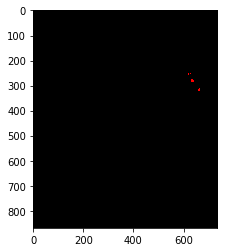

In [0]:
s_mask = gen_mask(s, pred_loc)
plt.imshow(s_mask)

**something goes wrong**

In [0]:
import gc
def _train_on_batch2(batch_size=2000):
  for i in range(0, len(normal), batch_size):
    print('training on batch {} / {}'.format(i//batch_size+1, len(normal)//batch_size))
    batch = slice(i, i + batch_size)
    for i, loc in enumerate(tumor[batch]):
      images = []
      labels = []
      patch = get_patch2(slide, *loc, 299, 299, 4)
      images.append(patch)
      labels.append(1)
      if i % 1000 == 0: print('processing {:<2f}%'.format(100 *(i + 1) / batch_size ))
    for i, loc in enumerate(normal[batch]):
      patch = get_patch2(slide, *loc, 299, 299, 4)
      images.append(patch)
      labels.append(0)
      if i % 1000 == 0: print('processing {:<2f}%'.format(100 *(i + 1) / batch_size ))
    images = np.array(images)    
    labels = np.array(labels)    
    features = conv_base.predict(images)
    train_features = np.reshape(features, (len(features), -1))
    del features
    history = model.fit(train_features, labels, epochs=1, batch_size=128, validation_split=0.1)
    plot_history(history)
    save_dir = '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/models/model_third_batch{}.h5'.format(i+1)
    model.save(save_dir)
    del images
    del labels
    del train_features

In [0]:
model = tf.keras.models.load_model('model_first.h5')

training on batch 1 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 546us/sample - loss: 0.0876 - acc: 0.9971 - val_loss: 6.2573e-07 - val_acc: 1.0000


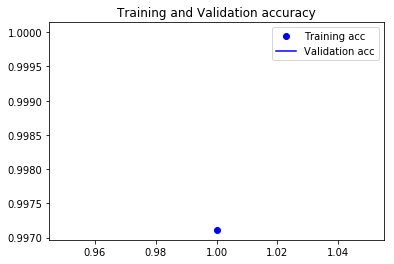

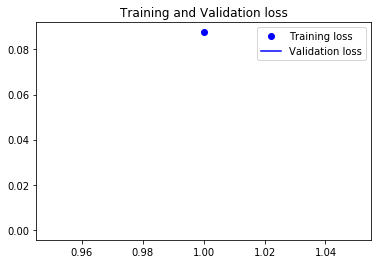

training on batch 2 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 502us/sample - loss: 0.0539 - acc: 0.9993 - val_loss: 2.0045e-07 - val_acc: 1.0000


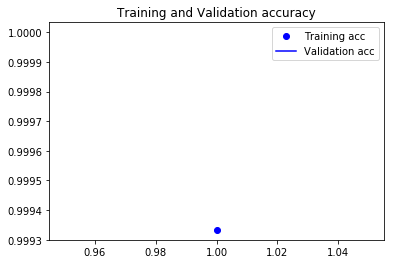

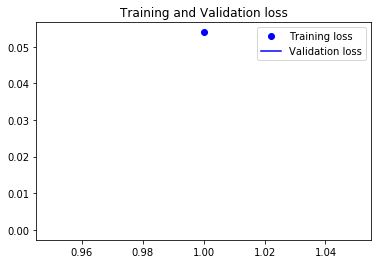

training on batch 3 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 491us/sample - loss: 0.0493 - acc: 0.9998 - val_loss: 1.6369e-07 - val_acc: 1.0000


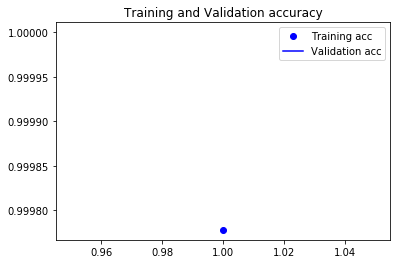

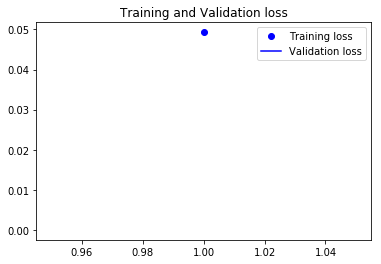

training on batch 4 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 497us/sample - loss: 0.0225 - acc: 0.9998 - val_loss: 2.8173e-08 - val_acc: 1.0000


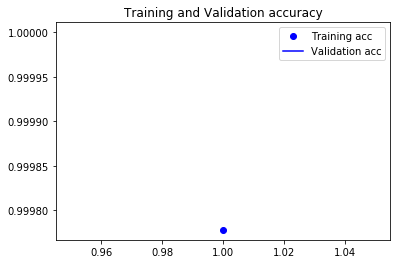

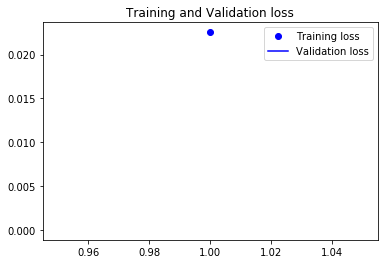

training on batch 5 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 514us/sample - loss: 0.0091 - acc: 0.9998 - val_loss: 2.6592e-08 - val_acc: 1.0000


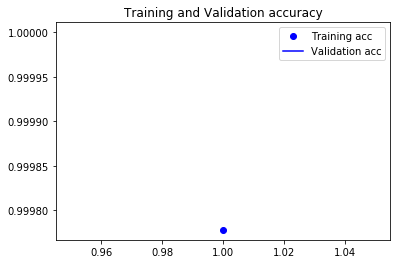

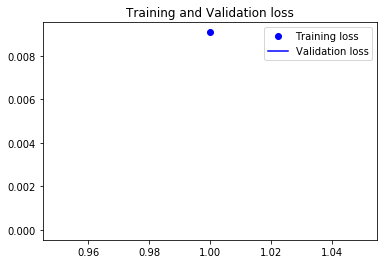

training on batch 6 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 492us/sample - loss: 0.0105 - acc: 0.9998 - val_loss: 5.3738e-09 - val_acc: 1.0000


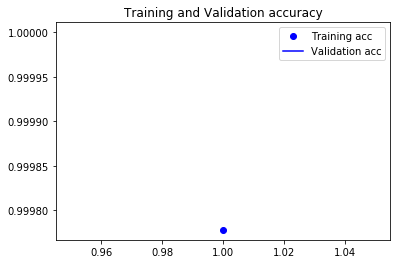

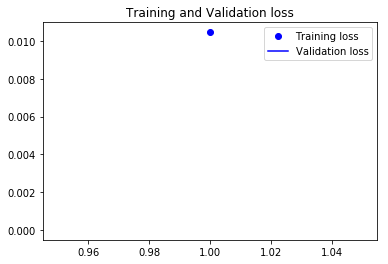

training on batch 7 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 487us/sample - loss: 0.0110 - acc: 0.9998 - val_loss: 2.5005e-09 - val_acc: 1.0000


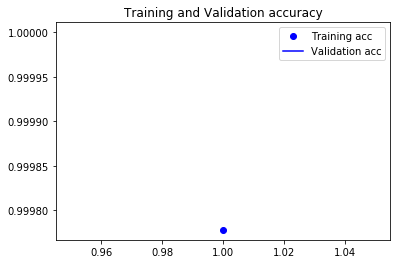

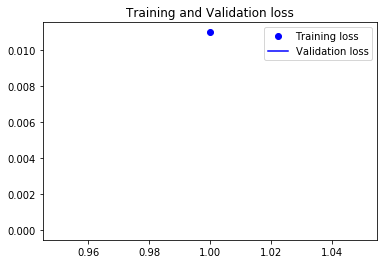

training on batch 8 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 491us/sample - loss: 0.0216 - acc: 0.9998 - val_loss: 1.8028e-10 - val_acc: 1.0000


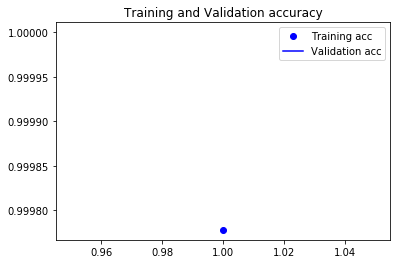

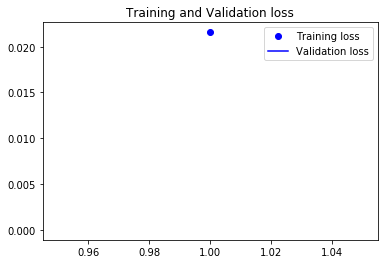

training on batch 9 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 495us/sample - loss: 0.0066 - acc: 0.9998 - val_loss: 8.1317e-10 - val_acc: 1.0000


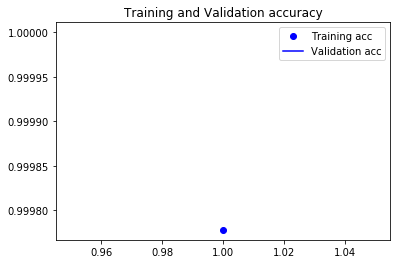

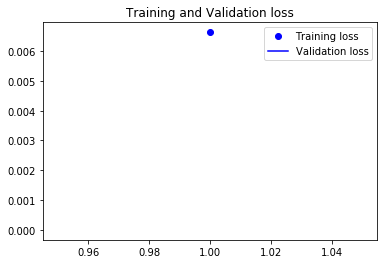

training on batch 10 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 501us/sample - loss: 0.0182 - acc: 0.9998 - val_loss: 7.6535e-10 - val_acc: 1.0000


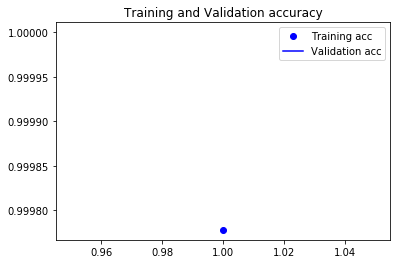

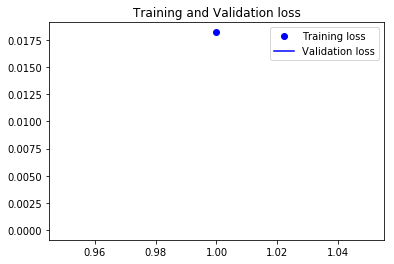

training on batch 11 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 488us/sample - loss: 0.0088 - acc: 0.9998 - val_loss: 1.8676e-08 - val_acc: 1.0000


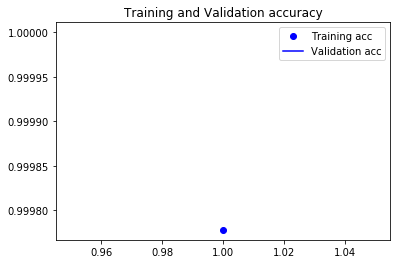

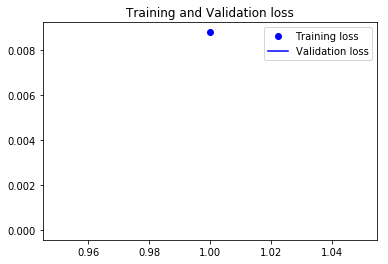

training on batch 12 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 3862 samples, validate on 430 samples
3862/3862 [==============================] - 2s 485us/sample - loss: 0.0079 - acc: 0.9997 - val_loss: 4.0324e-10 - val_acc: 1.0000


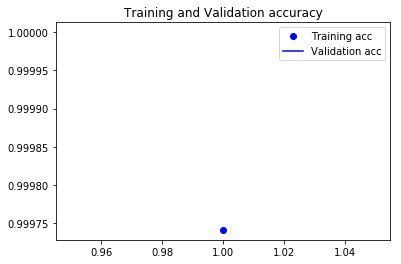

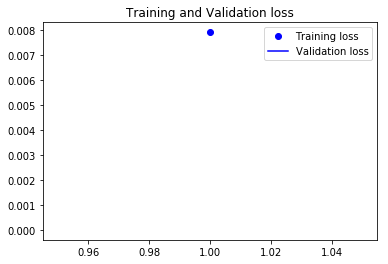

training on batch 1 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 496us/sample - loss: 0.0057 - acc: 0.9998 - val_loss: 6.7557e-10 - val_acc: 1.0000


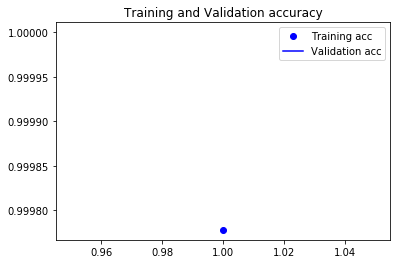

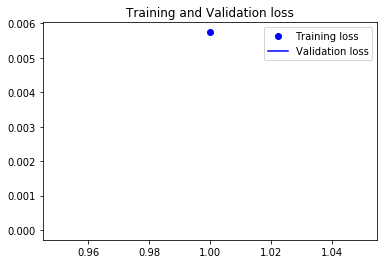

training on batch 2 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 482us/sample - loss: 0.0239 - acc: 0.9998 - val_loss: 7.4869e-10 - val_acc: 1.0000


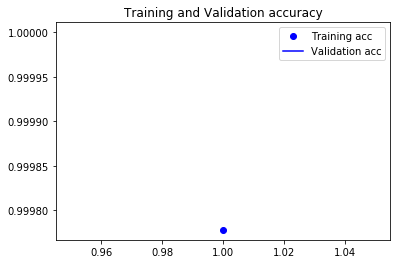

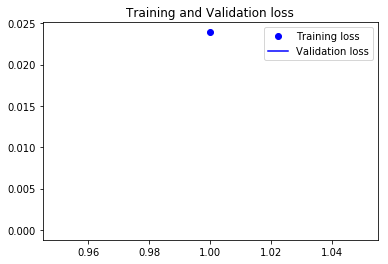

training on batch 3 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 478us/sample - loss: 0.0307 - acc: 0.9996 - val_loss: 7.0902e-09 - val_acc: 1.0000


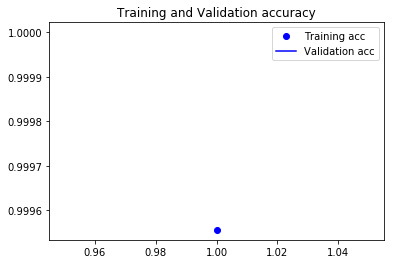

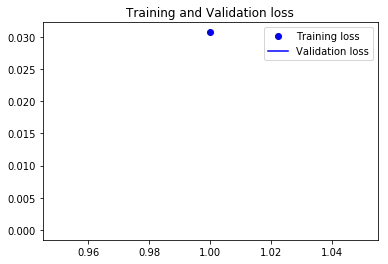

training on batch 4 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 484us/sample - loss: 0.0080 - acc: 0.9998 - val_loss: 5.9309e-10 - val_acc: 1.0000


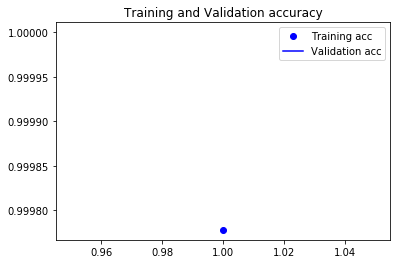

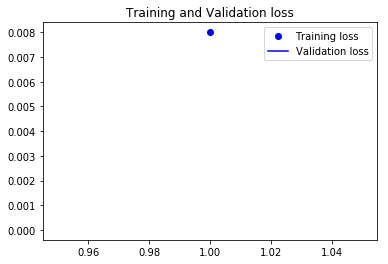

training on batch 5 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 506us/sample - loss: 0.0026 - acc: 0.9998 - val_loss: 9.4124e-10 - val_acc: 1.0000


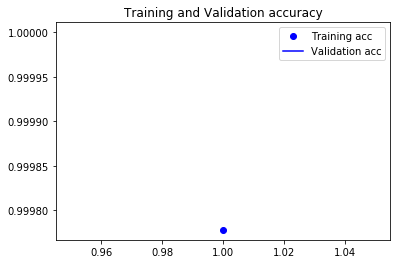

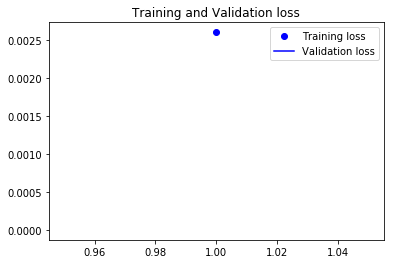

training on batch 6 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 485us/sample - loss: 0.0072 - acc: 0.9998 - val_loss: 2.0422e-10 - val_acc: 1.0000


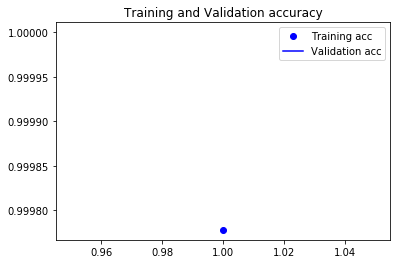

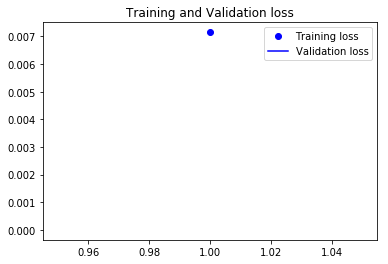

training on batch 7 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 484us/sample - loss: 0.0092 - acc: 0.9998 - val_loss: 3.7199e-10 - val_acc: 1.0000


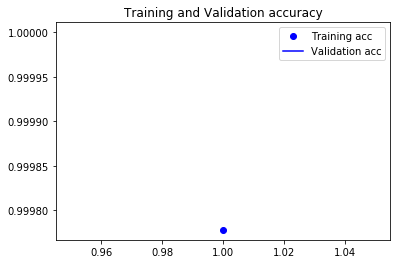

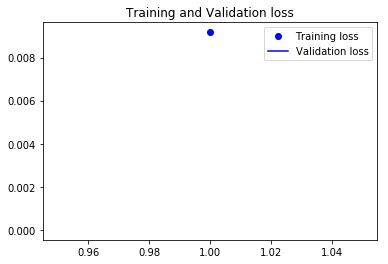

training on batch 8 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 484us/sample - loss: 0.0219 - acc: 0.9998 - val_loss: 1.7065e-10 - val_acc: 1.0000


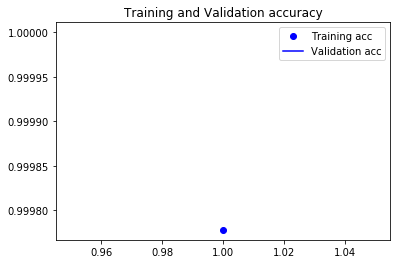

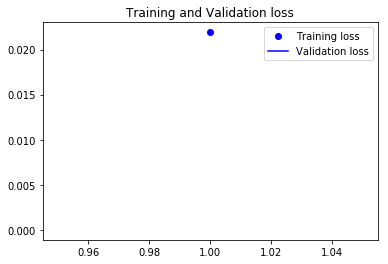

training on batch 9 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 492us/sample - loss: 0.0032 - acc: 0.9998 - val_loss: 1.7575e-10 - val_acc: 1.0000


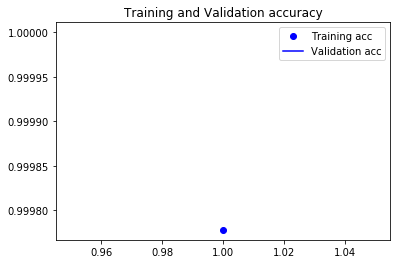

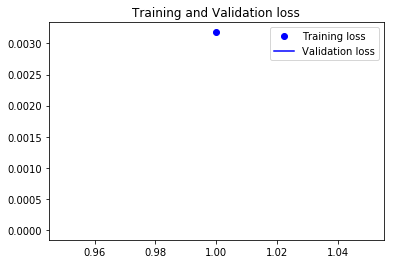

training on batch 10 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 498us/sample - loss: 0.0231 - acc: 0.9998 - val_loss: 6.4783e-10 - val_acc: 1.0000


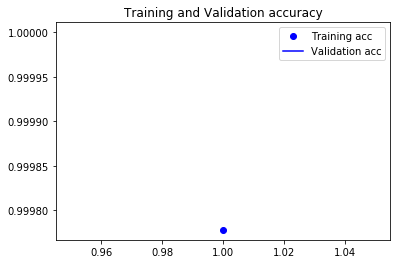

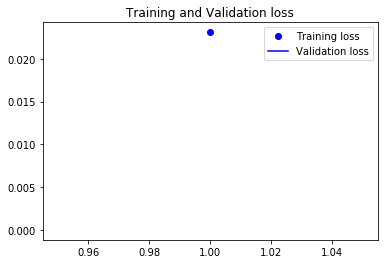

training on batch 11 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 490us/sample - loss: 0.0071 - acc: 0.9998 - val_loss: 3.4128e-10 - val_acc: 1.0000


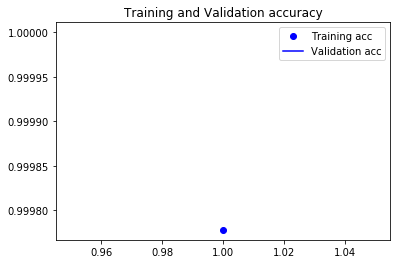

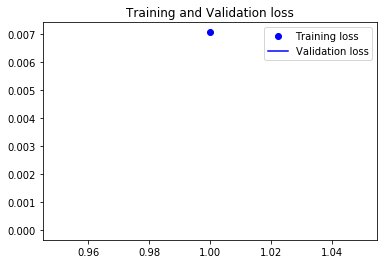

training on batch 12 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 3862 samples, validate on 430 samples
3862/3862 [==============================] - 2s 479us/sample - loss: 0.0119 - acc: 0.9997 - val_loss: 2.0149e-10 - val_acc: 1.0000


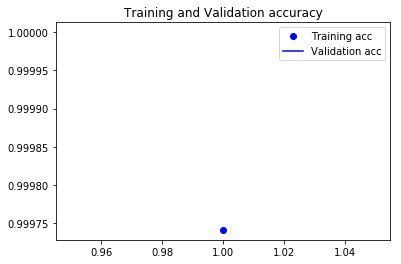

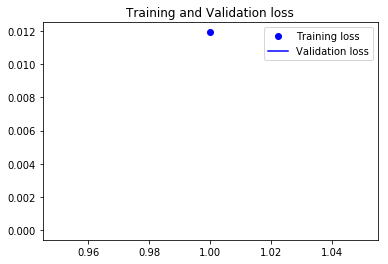

training on batch 1 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 491us/sample - loss: 0.0063 - acc: 0.9998 - val_loss: 1.3351e-10 - val_acc: 1.0000


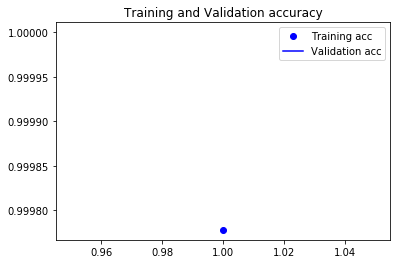

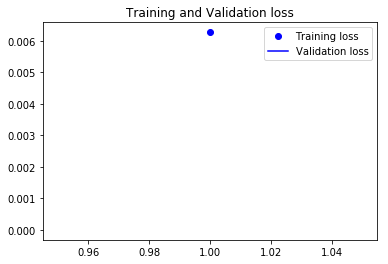

training on batch 2 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 527us/sample - loss: 0.0206 - acc: 0.9998 - val_loss: 3.3718e-10 - val_acc: 1.0000


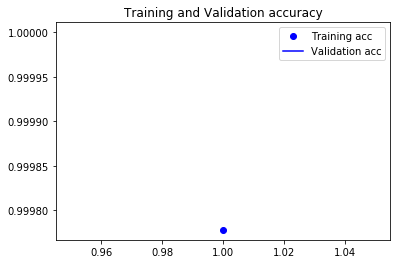

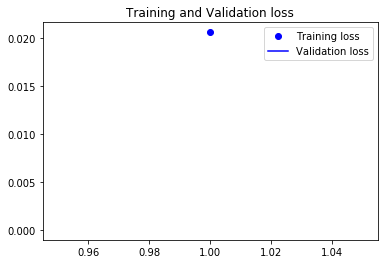

training on batch 3 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 491us/sample - loss: 0.0183 - acc: 0.9998 - val_loss: 5.9702e-09 - val_acc: 1.0000


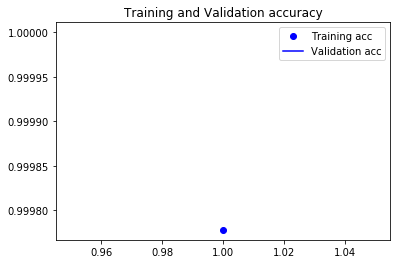

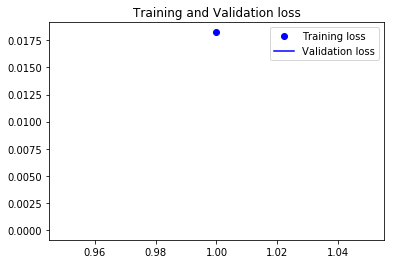

training on batch 4 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 494us/sample - loss: 0.0162 - acc: 0.9996 - val_loss: 2.2283e-10 - val_acc: 1.0000


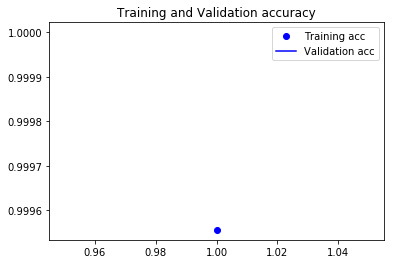

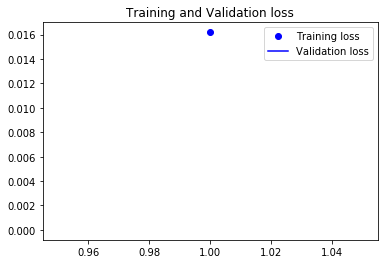

training on batch 5 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 504us/sample - loss: 0.0075 - acc: 0.9998 - val_loss: 4.7020e-10 - val_acc: 1.0000


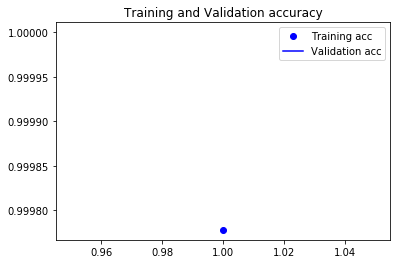

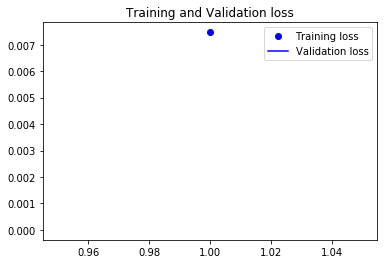

training on batch 6 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 512us/sample - loss: 0.0052 - acc: 0.9998 - val_loss: 1.7020e-10 - val_acc: 1.0000


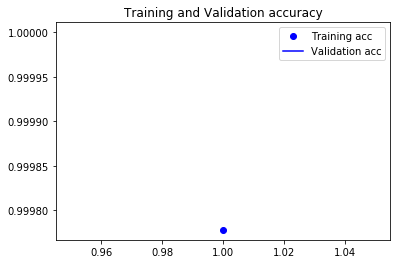

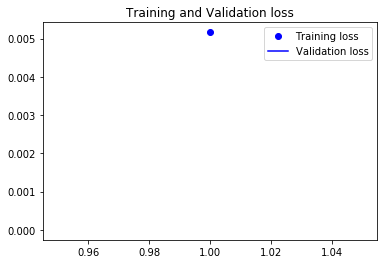

training on batch 7 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 498us/sample - loss: 0.0093 - acc: 0.9998 - val_loss: 1.6542e-10 - val_acc: 1.0000


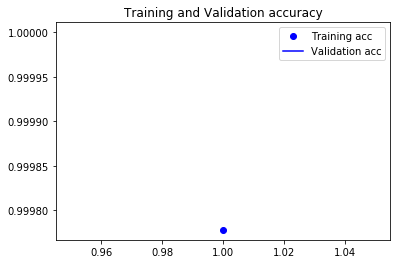

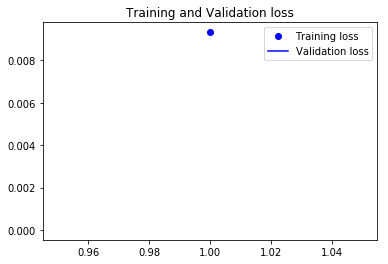

training on batch 8 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 493us/sample - loss: 0.0117 - acc: 0.9998 - val_loss: 2.0923e-10 - val_acc: 1.0000


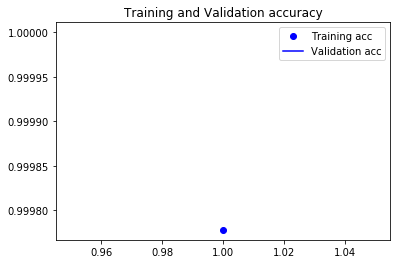

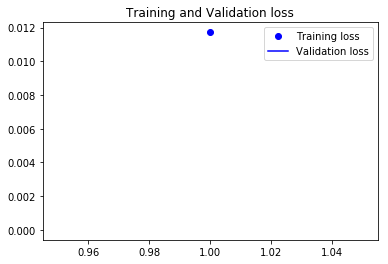

training on batch 9 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 489us/sample - loss: 0.0069 - acc: 0.9998 - val_loss: 5.7436e-11 - val_acc: 1.0000


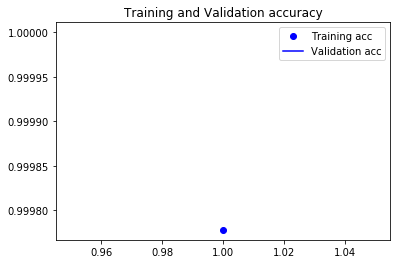

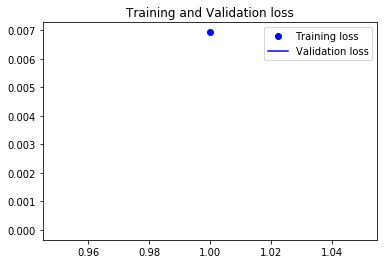

training on batch 10 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 510us/sample - loss: 0.0223 - acc: 0.9998 - val_loss: 3.7969e-10 - val_acc: 1.0000


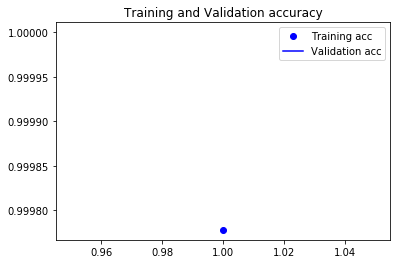

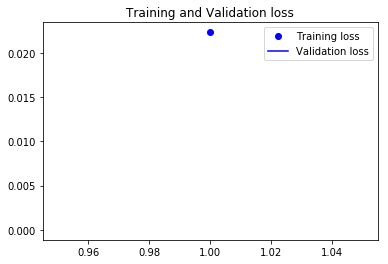

training on batch 11 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 489us/sample - loss: 0.0086 - acc: 0.9998 - val_loss: 1.4208e-10 - val_acc: 1.0000


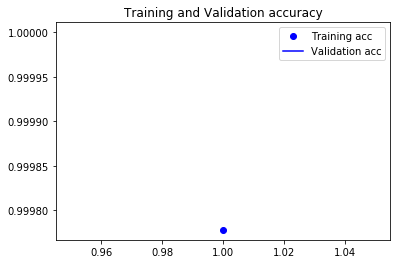

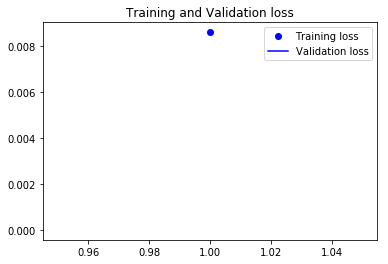

training on batch 12 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 3862 samples, validate on 430 samples
3862/3862 [==============================] - 2s 498us/sample - loss: 0.0080 - acc: 0.9997 - val_loss: 6.5581e-11 - val_acc: 1.0000


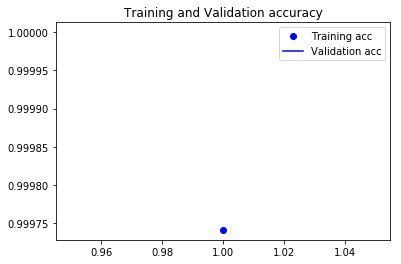

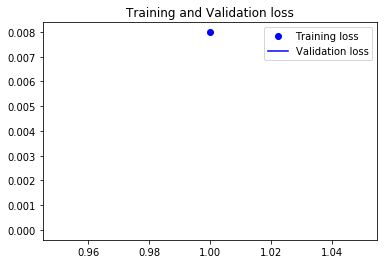

training on batch 1 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 493us/sample - loss: 0.0063 - acc: 0.9998 - val_loss: 5.5364e-11 - val_acc: 1.0000


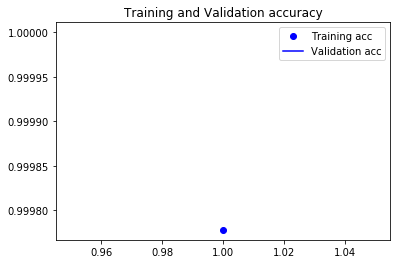

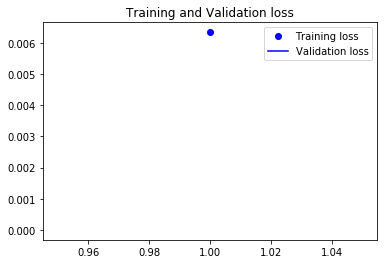

training on batch 2 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 497us/sample - loss: 0.0360 - acc: 0.9998 - val_loss: 1.4589e-10 - val_acc: 1.0000


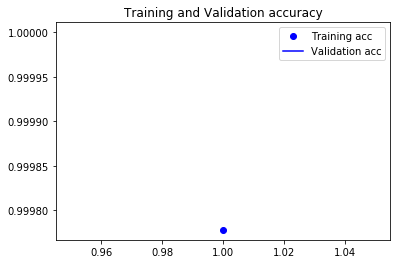

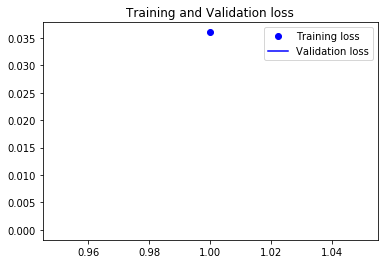

training on batch 3 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 495us/sample - loss: 0.0190 - acc: 0.9998 - val_loss: 5.1604e-09 - val_acc: 1.0000


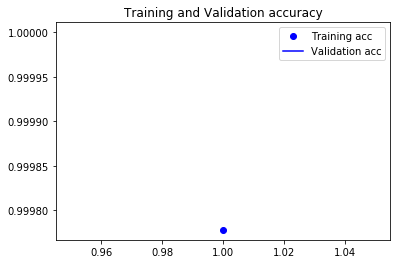

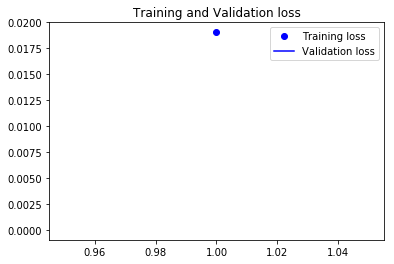

training on batch 4 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 509us/sample - loss: 0.0090 - acc: 0.9998 - val_loss: 1.3000e-10 - val_acc: 1.0000


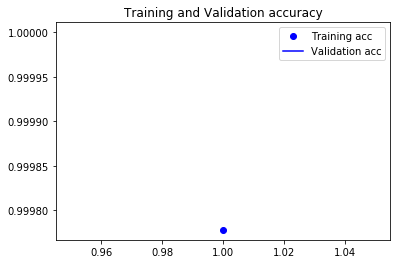

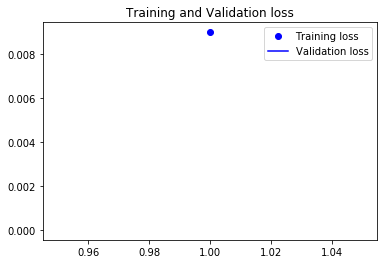

training on batch 5 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 503us/sample - loss: 0.0073 - acc: 0.9998 - val_loss: 3.5484e-10 - val_acc: 1.0000


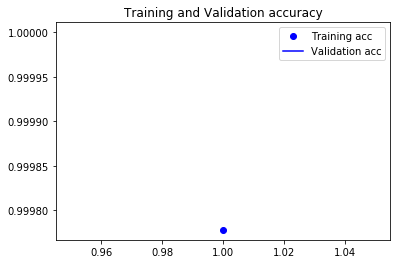

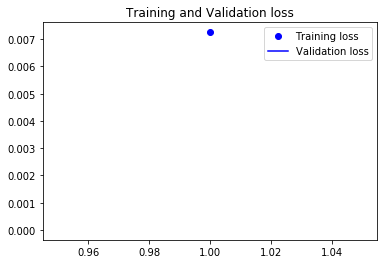

training on batch 6 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
Train on 4500 samples, validate on 501 samples
4500/4500 [==============================] - 2s 494us/sample - loss: 0.0066 - acc: 0.9998 - val_loss: 5.7074e-11 - val_acc: 1.0000


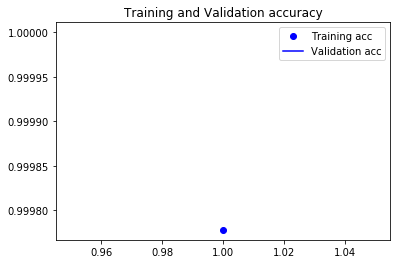

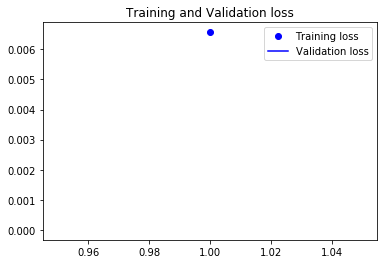

training on batch 7 / 11
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%


In [0]:
EPOCHS = 5
for epoch in range(EPOCHS):
  _train_on_batch2(batch_size=5000)

**5 / 4 debugging on my training process**

In [0]:
import gc
def _train_on_batch3(batch_size=2000):
  for i in range(0, len(normal), batch_size):
    print('training on batch {} / {}'.format(i//batch_size+1, len(normal)//batch_size))
    batch = slice(i, i + batch_size)
    print('current first 10 locations:\ntumor {}\nnormal{}'.format(str(tumor[batch][:10]), str(normal[batch][:10])))
    images = []
    labels = [] # should be here
    for j, loc in enumerate(tumor[batch]):
      patch = get_patch2(slide, *loc, 299, 299, 4)
      images.append(patch)
      labels.append(1)
      if j % 1000 == 0: print('processing {:<2f}%'.format(100 *(j + 1) / batch_size ))
    for j, loc in enumerate(normal[batch]):
      patch = get_patch2(slide, *loc, 299, 299, 4)
      images.append(patch)
      labels.append(0)
      if j % 1000 == 0: print('processing {:<2f}%'.format(100 *(j + 1) / batch_size ))
    images = np.array(images)    
    labels = np.array(labels)    
    features = conv_base.predict(images)
    train_features = np.reshape(features, (len(features), -1))
    del features
    model.fit(train_features, labels, epochs=1, batch_size=128)
    save_dir = '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/models/model_0504_batchId{}.h5'.format(i//batch_size + 1)
    model.save(save_dir)
    del images
    del labels
    del train_features

In [0]:
model = tf.keras.models.load_model('model_first.h5')

In [21]:
EPOCHS = 5
for epoch in range(EPOCHS):
  print('EPOCH: {} / {}'.format(epoch + 1, EPOCHS))
  _train_on_batch3(batch_size=5000)

EPOCH: 1 / 5
training on batch 1 / 11
current first 10 locations:
tumor [(177, 440), (583, 385), (220, 311), (273, 641), (276, 628), (294, 289), (317, 650), (296, 663), (331, 643), (287, 457)]
normal[(592, 344), (220, 526), (254, 701), (561, 287), (521, 121), (292, 205), (335, 258), (133, 302), (288, 726), (215, 110)]
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
processing 0.020000%
processing 20.020000%
processing 40.020000%
processing 60.020000%
processing 80.020000%
10000/10000 [==============================] - 6s 635us/sample - loss: 1.9272 - acc: 0.7530
training on batch 2 / 11
current first 10 locations:
tumor [(248, 425), (535, 394), (371, 160), (180, 455), (529, 617), (326, 706), (344, 731), (489, 667), (249, 605), (178, 319)]
normal[(214, 425), (305, 238), (109, 444), (526, 599), (476, 479), (331, 129), (505, 490), (164, 313), (539, 644), (186, 472)]
processing 0.020000%
processing 20.020000%
processing 40.020000

In [22]:
# model_0504_batchId12.h5 is the latest model for now
#!ls

gdrive	model_first.h5	sample_data


**model is saved on gdrive**

## test the model

1. try to use @tf.function to speed up part of the code